# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [18]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [19]:
# add any additional libaries you need here

import seaborn as sns
import plotly.express as px

In [20]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [21]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [22]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [23]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot: xlabel='category'>

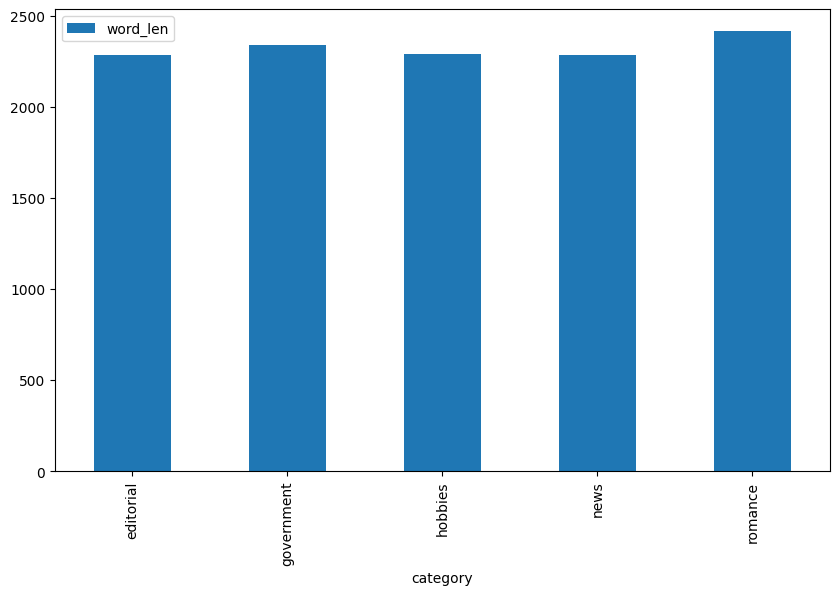

In [24]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [25]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['text'])
count_text_vectors.shape

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [26]:
count_text_vectorizer.get_feature_names_out()

array(['00', '000', '10', ..., 'youth', 'zone', 'zoning'], dtype=object)

In [103]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
print(tfidf_text_vectors.shape)


(166, 4941)


C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



AttributeError: get_feature_names_out not found

In [113]:
tfidf_text_vectorizer.fit(df['text']).get_feature_names_out()

array(['00', '000', '10', ..., 'youth', 'zone', 'zoning'], dtype=object)

In [28]:
tfidf_text_vectorizer.get_feature_names_out()

array(['00', '000', '10', ..., 'youth', 'zone', 'zoning'], dtype=object)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: `count_text_vectors` is a python object that contains a 166x4941 sparse matrix of type '<class 'numpy.int64'>' with 72541 stored elements in Compressed Sparse Row format. The numbers are a matrix of text documents to token counts. This matrix doesn’t include words from our stopwords list. It also ignores terms that have a document frequency strictly lower than 5. It also ignores terms that have a document frequency strictly higher than 70%.


`tfidf_text_vectors` is a python object that contains a 166x4941 sparse matrix of type '<class 'numpy.int64'>' with 72541 stored elements in Compressed Sparse Row format. The numbers are a matrix of term-frequency times inverse document-frequency. This matrix doesn’t include words from our stopwords list. It also ignores terms that have a document frequency strictly lower than 5. It also ignores terms that have a document frequency strictly higher than 70%.


## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [29]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_nmf_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_nmf_text_matrix = nmf_text_model.components_

In [32]:
# Plot PCA of Predictions
fig = px.scatter(W_nmf_text_matrix, x=0, y=1, color=df["category"])
fig.show()

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [ ]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


<AxesSubplot: xlabel='Predicted Label: Model Topics', ylabel='True Label: Original Brown Topics'>

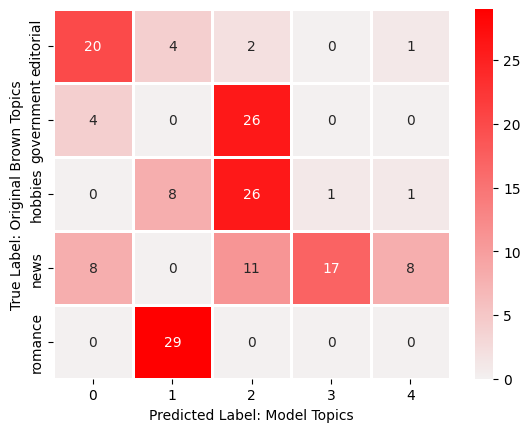

In [33]:
# Your code here
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_nmf_text_matrix]

# Add to the df
df_new['nmf_pred_topic_num'] = predicted_topics

# Create Crosstab
acc_crosstab = pd.crosstab(df_new["category"], df_new["nmf_pred_topic_num"], dropna=False)

# Custom Color Palette
hot_palette =  sns.color_palette("light:r", as_cmap=True)

# Plot Heatmap of Aggreement.
ax = sns.heatmap(acc_crosstab,cmap=hot_palette,linewidths=1,annot=True)
ax.set(xlabel="Predicted Label: Model Topics", ylabel="True Label: Original Brown Topics")
ax

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Looking at the NMF model compared to the original Brown categories, it appears that our model does a good job predicting the Romance and Editorial categories. Our model seems to have a hard time differentiating between hobbies and government categories and struggles reliably predicting the news category.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [34]:
# Your code here
lsa_text_model = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
W_lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_text_matrix = lsa_text_model.components_


In [35]:
# Plot PCA of Predictions
fig = px.scatter(W_lsa_text_matrix, x=0, y=1, color=df["category"])
fig.show()

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [36]:
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.04)
  kennedy (0.81)
  laos (0.77)

Topic 03
  mrs (29.56)
  club (6.57)
  game (6.15)
  jr (5.64)
  dallas (5.31)

Topic 04
  game (4.38)
  league (3.14)
  baseball (3.12)
  ball (2.98)
  team (2.85)


<AxesSubplot: xlabel='Predicted Label: Model Topics', ylabel='True Label: Original Brown Topics'>

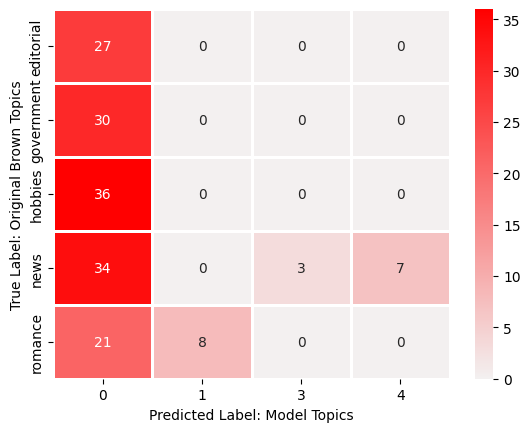

In [37]:
# Your code here
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_lsa_text_matrix]

# Add to the df
df_new['lsa_pred_topic_num'] = predicted_topics

# Create Crosstab
acc_crosstab = pd.crosstab(df_new["category"], df_new["lsa_pred_topic_num"], dropna=False)

# Custom Color Palette
hot_palette =  sns.color_palette("light:r", as_cmap=True)

# Plot Heatmap of Aggreement.
ax = sns.heatmap(acc_crosstab,cmap=hot_palette,linewidths=1,annot=True)
ax.set(xlabel="Predicted Label: Model Topics", ylabel="True Label: Original Brown Topics")
ax

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: This model did a terrible job of finding topics that align with the original categories. 

Q: What is your interpretation of the display topics output? 

A: 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [38]:
# Fit your LDA model here

lda_text_model = LatentDirichletAllocation(n_components=5, random_state=0)
W_lda_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [39]:
# Plot PCA of Predictions
fig = px.scatter(W_lda_text_matrix, x=0, y=1, color=df["category"])
fig.show()

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [40]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  discretion (0.02)
  construct (0.02)
  categories (0.02)
  founder (0.02)
  combinations (0.02)

Topic 01
  said (0.27)
  mr (0.16)
  state (0.15)
  mrs (0.14)
  president (0.11)

Topic 02
  discretion (0.02)
  construct (0.02)
  categories (0.02)
  founder (0.02)
  combinations (0.02)

Topic 03
  discretion (0.02)
  construct (0.02)
  categories (0.02)
  founder (0.02)
  combinations (0.02)

Topic 04
  discretion (0.02)
  construct (0.02)
  categories (0.02)
  founder (0.02)
  combinations (0.02)


<AxesSubplot: xlabel='Predicted Label: Model Topics', ylabel='True Label: Original Brown Topics'>

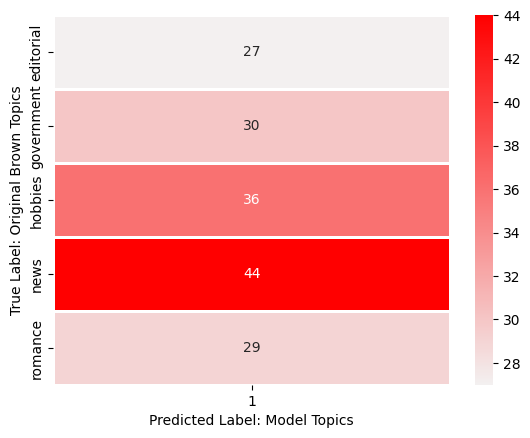

In [41]:
# Your code here
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_lda_text_matrix]

# Add to the df
df_new['lda_pred_topic_num'] = predicted_topics

# Create Crosstab
acc_crosstab = pd.crosstab(df_new["category"], df_new["lda_pred_topic_num"], dropna=False)

# Custom Color Palette
hot_palette =  sns.color_palette("light:r", as_cmap=True)

# Plot Heatmap of Aggreement.
ax = sns.heatmap(acc_crosstab,cmap=hot_palette,linewidths=1,annot=True)
ax.set(xlabel="Predicted Label: Model Topics", ylabel="True Label: Original Brown Topics")
ax

Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model suggest that there really isn't much statistical differneces in terms between the topics choosen.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: LDA has only one

In [42]:
# I'm not able to run this procedure with my setup. 
# I'm not willing to unistall and reinstall another version of python as I use this set-up for my work and I'm using my work computer to complete this project.
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, tfidf_text_vectors, tfidf_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [43]:
W_lda_text_matrix.show_topics(formatted=False)

AttributeError: 'numpy.ndarray' object has no attribute 'show_topics'

In [53]:
from collections import Counter

topics = lda_text_model.get_feature_names_out()
data_flat = [w for w_list in tfidf_text_vectors for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

TypeError: unhashable type: 'csr_matrix'

array(['latentdirichletallocation0', 'latentdirichletallocation1',
       'latentdirichletallocation2', 'latentdirichletallocation3',
       'latentdirichletallocation4'], dtype=object)

In [ ]:
import pyLDAvis.gensim_models
import gensim.corpora as corpora

id2word = corpora.Dictionary(count_text_vectors.toarray())


len(id2word)

55

In [ ]:
# count_text_vectors.get_feature_names_out()
count_text_vectors.toarray()
# list(np.array(cv_fit.sum(axis=0))[0])

array([[ 0,  3,  0, ...,  0,  0,  0],
       [ 0,  3,  0, ...,  0,  2,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  4, ...,  0,  0,  0],
       [ 0,  8,  1, ...,  0,  0,  0],
       [11,  0,  2, ...,  0,  0,  0]], dtype=int64)

In [ ]:
# Fit your LDA model here

lda_text_model = LatentDirichletAllocation(n_components=5, random_state=0)
W_lda_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [87]:
processed_documents = {}
for document in documents:
    processed_sentences = []
    sentences = brown.sents(document)
    for sentence in sentences:
        processed_sentences.append([word.lower() for word in sentence if word.isalnum() and word not in stopwords])
    processed_documents[document] = processed_sentences

NameError: name 'documents' is not defined

In [ ]:
def get_topic_assignment(processed_documents, n_topics):
    np.random.seed(42)
    topic_assignment = {}
    for document, sentences in processed_documents.items():
        words = list(itertools.chain(*sentences))
        topics_assigned = np.random.choice(range(n_topics), len(words), replace=True)
        topic_assignment[document] = list(zip(words, topics_assigned))
    return topic_assignment

initial_topic_assignment = get_topic_assignment(processed_documents, n_topics)

In [ ]:
def get_CWT_matrix(topic_assignment):
    word_topics = topic_assignment.values()
    count_word_topics_dict = Counter(list(itertools.chain(*word_topics)))
    CWT_words = np.array(list(count_word_topics_dict.keys()))[:, 0]
    CWT_words = list(map(lambda x: token2int[x], CWT_words))
    CWT_topics = list(map(int, np.array(list(count_word_topics_dict.keys()))[:, 1]))
    counts = list(count_word_topics_dict.values())
    CWT = np.zeros((n_tokens, n_topics), dtype='int')
    CWT[CWT_words, CWT_topics] = counts
    return CWT

CWT = get_CWT_matrix(initial_topic_assignment)

CWT

In [88]:
def get_CDT_matrix(topic_assignment):
    CDT = np.zeros((n_documents, n_topics), dtype='int')
    for document, word_topics in topic_assignment.items():
        count_topic_dict = Counter(list(map(int, np.array(word_topics)[:, 1])))
        topic_indices = list(count_topic_dict.keys())
        topic_counts = list(count_topic_dict.values())
        CDT[document2int[document], topic_indices] = topic_counts 
    return CDT

CDT = get_CDT_matrix(initial_topic_assignment)

CDT

NameError: name 'initial_topic_assignment' is not defined

In [91]:
len(H_lda_text_matrix[0])

4941

In [97]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
# 
pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(W_lda_text_matrix, H_lda_text_matrix, W_lda_text_matrix) # tfidf_text_vectors   count_text_vectors
vis


TypeError: prepare() missing 2 required positional arguments: 'vocab' and 'term_frequency'

In [96]:
len(W_lda_text_matrix)

166

In [ ]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['text'])
count_text_vectors.shape

In [71]:
count_text_vectors.toarray()

array([[ 0,  3,  0, ...,  0,  0,  0],
       [ 0,  3,  0, ...,  0,  2,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  4, ...,  0,  0,  0],
       [ 0,  8,  1, ...,  0,  0,  0],
       [11,  0,  2, ...,  0,  0,  0]], dtype=int64)

In [70]:
from gensim.corpora import Dictionary

id2word = Dictionary(tfidf_text_vectorizer.get_feature_names_out())

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [124]:
lda_text_model.components_


array([[0.20001383, 0.20000661, 0.20000784, ..., 0.200009  , 0.20001497,
        0.2000154 ],
       [0.60211779, 3.56008841, 1.79296626, ..., 0.79801466, 0.42446254,
        0.35318368],
       [0.20001383, 0.20000661, 0.20000784, ..., 0.200009  , 0.20001497,
        0.2000154 ],
       [0.20001383, 0.20000661, 0.20000784, ..., 0.200009  , 0.20001497,
        0.2000154 ],
       [0.20001383, 0.20000661, 0.20000784, ..., 0.200009  , 0.20001497,
        0.2000154 ]])

In [151]:
#function for lemmatization

import gensim.corpora as corpora

#cleaning the text 

def tokeniz(sentences):

    for sentence in sentences:

        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))



#removing stopwords, creating bigrams and lemmatizing the text

data_lemmatized = list(tokeniz(df["text"]))

#creating a dictionary

gensim_dictionary = corpora.Dictionary(data_lemmatized)

#building a corpus for the topic model

texts = data_lemmatized
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

In [152]:
gensim_dictionary = corpora.Dictionary(df["text"])

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [153]:
gensim_dictionary[0]

'abandoning'

In [154]:
df["text"][0]

"Assembly session brought much good The General Assembly , which adjourns today , has performed in an atmosphere of crisis and struggle from the day it convened . It was faced immediately with a showdown on the schools , an issue which was met squarely in conjunction with the governor with a decision not to risk abandoning public education . There followed the historic appropriations and budget fight , in which the General Assembly decided to tackle executive powers . The final decision went to the executive but a way has been opened for strengthening budgeting procedures and to provide legislators information they need . Long-range planning of programs and ways to finance them have become musts if the state in the next few years is to avoid crisis-to-crisis government . This session , for instance , may have insured a financial crisis two years from now . In all the turmoil , some good legislation was passed . Some other good bills were lost in the shuffle and await future action . Ce

In [155]:
data_lemmatized[0]

['assembly',
 'session',
 'brought',
 'much',
 'good',
 'the',
 'general',
 'assembly',
 'which',
 'adjourns',
 'today',
 'has',
 'performed',
 'in',
 'an',
 'atmosphere',
 'of',
 'crisis',
 'and',
 'struggle',
 'from',
 'the',
 'day',
 'it',
 'convened',
 'it',
 'was',
 'faced',
 'immediately',
 'with',
 'showdown',
 'on',
 'the',
 'schools',
 'an',
 'issue',
 'which',
 'was',
 'met',
 'squarely',
 'in',
 'conjunction',
 'with',
 'the',
 'governor',
 'with',
 'decision',
 'not',
 'to',
 'risk',
 'abandoning',
 'public',
 'education',
 'there',
 'followed',
 'the',
 'historic',
 'appropriations',
 'and',
 'budget',
 'fight',
 'in',
 'which',
 'the',
 'general',
 'assembly',
 'decided',
 'to',
 'tackle',
 'executive',
 'powers',
 'the',
 'final',
 'decision',
 'went',
 'to',
 'the',
 'executive',
 'but',
 'way',
 'has',
 'been',
 'opened',
 'for',
 'strengthening',
 'budgeting',
 'procedures',
 'and',
 'to',
 'provide',
 'legislators',
 'information',
 'they',
 'need',
 'long',
 'range'

In [156]:
#creating the LDA model 

import pyLDAvis.gensim_models
from gensim.test.utils import common_corpus
import gensim.models.ldamodel

lda_model = gensim.models.ldamodel.LdaModel(

   corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=5, random_state=100, 

   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True

)

In [157]:
from pyLDAvis.gensim_models import prepare
vis = prepare(lda_model, gensim_corpus, gensim_dictionary, mds='pcoa')
vis.topic_info


C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyLDAvis\_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



,Term,Freq,Total,Category,logprob,loglift
774,the,21619.000000,21619.000000,Default,30.0000,30.0000
365,he,2300.000000,2300.000000,Default,29.0000,29.0000
3785,she,935.000000,935.000000,Default,28.0000,28.0000
874,you,1340.000000,1340.000000,Default,27.0000,27.0000
3677,her,839.000000,839.000000,Default,26.0000,26.0000
...,...,...,...,...,...,...
642,rate,2.043889,64.747408,Topic5,-6.2056,2.3147
852,what,2.052860,548.928262,Topic5,-6.2012,0.1816
1509,aid,1.874440,90.052485,Topic5,-6.2921,1.8982
1548,body,1.857278,75.191699,Topic5,-6.3013,2.0694


In [158]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.082776 -0.071214       1        1  42.930325
2      0.104243  0.123238       2        1  23.071597
1      0.043400  0.022840       3        1  21.123039
3      0.072556 -0.081552       4        1  12.563163
4     -0.302976  0.006687       5        1   0.311877, topic_info=      Term          Freq         Total Category  logprob  loglift
774    the  21619.000000  21619.000000  Default  30.0000  30.0000
365     he   2300.000000   2300.000000  Default  29.0000  29.0000
3785   she    935.000000    935.000000  Default  28.0000  28.0000
874    you   1340.000000   1340.000000  Default  27.0000  27.0000
3677   her    839.000000    839.000000  Default  26.0000  26.0000
...    ...           ...           ...      ...      ...      ...
642   rate      2.043889     64.747408   Topic5  -6.2056   2.3147
852   what      2.052860    548.928262   Topic5  -6.2012   0.1816
1509   aid      1.874440     90.052485   Topic5  -6.2921   1.8982
1548  body      1.857278     75.191699   Topic5  -6.3013   2.0694
2133  days      1.826164    137.019836   Topic5  -6.3182   1.4524

[427 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
22079      5  0.650997   abscesses
22080      5  0.650997  acetonemia
22420      4  0.978245     acrylic
2025       1  0.875550         act
2025       2  0.024780         act
...      ...       ...         ...
874        4  0.315537         you
3852       1  0.073102        your
3852       2  0.314743        your
3852       3  0.052796        your
3852       4  0.560445        your

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 
